In [1]:
import numpy as np
import pandas as pd
import numpy as np
import cv2
import os
import pickle
import math
import tqdm
from tqdm import trange
from matplotlib import pyplot as plt
import seaborn as sns
from ResNet import *
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

In [3]:
# CPU or GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device='cpu'

In [4]:
#open resize data(64*64*3)
with open('./Data/resized_train_data.pickle', 'rb') as f :
    train = pickle.load(f)
with open('./Data/resized_valid_data.pickle', 'rb') as f :
    valid = pickle.load(f)
with open('./Data/resized_test_data.pickle', 'rb') as f :
    test = pickle.load(f)

In [60]:
#open original data(512*512*3)
with open('./Data/train_data.pickle', 'rb') as f :
    train = pickle.load(f)
with open('./Data/valid_data.pickle', 'rb') as f :
    valid = pickle.load(f)
with open('./Data/test_data.pickle', 'rb') as f :
    test = pickle.load(f)

In [5]:
X_train = train['train_data']
Y_train = train['train_label']
X_val = valid['valid_data']
Y_val = valid['valid_label']
X_test = test['test_data']
Y_test = test['test_label']

In [6]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

In [7]:
len(X_test)

10142

In [8]:
#標準化
def custom_normalization(data, std, mean):
    return (data - mean) / std

mean, std = X_train.mean(), X_train.std()
X_train = custom_normalization(X_train, mean, std)
mean, std = X_val.mean(), X_val.std()
X_val = custom_normalization(X_val, mean, std)
mean, std = X_test.mean(), X_test.std()
X_test = custom_normalization(X_test, mean, std)

In [9]:
X_train = np.transpose(X_train,(0,3,1,2))
X_val = np.transpose(X_val,(0,3,1,2))
X_test = np.transpose(X_test,(0,3,1,2))

In [10]:
#使用pytorch封装的dataloader进行训练和预测

#use_gpu = torch.cuda.is_available()
batch_size = 1000
#kwargs = {'num_workers': 2, 'pin_memory': True} if use_gpu else {}

train_x, train_y = torch.from_numpy(X_train).float(), torch.from_numpy(Y_train.astype(int))
val_x, val_y = torch.from_numpy(X_val).float(),torch.from_numpy(Y_val.astype(int))
test_x, test_y = torch.from_numpy(X_test).float(),torch.from_numpy(Y_test.astype(int))

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(dataset=val_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=10142)

In [11]:
# Hyper parameters
num_epochs = 500
num_classes = 6
learning_rate = 0.001

In [ ]:
model = resnet34().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [13]:
#print(model)

In [ ]:
%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []
valid_accuracy_list = []
max_valid_accuracy = 0.0
for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    correct = 0
    total = 0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU if you have.
        data = data.to(device)
        target = target.to(device)
        
        #mean, std = data.mean(), data.std()
        #data = custom_normalization(data, mean, std)
        '''Your code here'''
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)

    # validate-the-model
    model.eval()
    for data, target in valid_loader:

        data = data.to(device)
        target = target.to(device)
        
        #mean, std = data.mean(), data.std()
        #data = custom_normalization(data, mean, std)
        
        output = model(data)
        loss = criterion(output, target)
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
        total += output.size(0)
        correct += (output.argmax(dim=1) == target).sum().item()
        
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accuracy = (100 * correct / total)
    valid_accuracy_list.append(valid_accuracy)
    if max_valid_accuracy<=valid_accuracy:
        max_valid_accuracy=valid_accuracy
        # Save 
        torch.save(model.state_dict(), 'ResNet34_512.ckpt')
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValid Accuracy of the model: {} %'.format(
        epoch, train_loss, valid_loss,(100 * correct / total)))

Epoch: 1 	Training Loss: 1.618056 	Validation Loss: 1.784122 	Valid Accuracy of the model: 25.946969696969695 %
Epoch: 2 	Training Loss: 1.420813 	Validation Loss: 1.784051 	Valid Accuracy of the model: 25.946969696969695 %
Epoch: 3 	Training Loss: 1.376873 	Validation Loss: 1.535190 	Valid Accuracy of the model: 50.378787878787875 %
Epoch: 4 	Training Loss: 1.356861 	Validation Loss: 1.543011 	Valid Accuracy of the model: 49.621212121212125 %
Epoch: 5 	Training Loss: 1.340763 	Validation Loss: 1.608898 	Valid Accuracy of the model: 42.99242424242424 %
Epoch: 6 	Training Loss: 1.336161 	Validation Loss: 1.471663 	Valid Accuracy of the model: 56.81818181818182 %
Epoch: 7 	Training Loss: 1.333926 	Validation Loss: 1.450371 	Valid Accuracy of the model: 59.09090909090909 %
Epoch: 8 	Training Loss: 1.326360 	Validation Loss: 1.388768 	Valid Accuracy of the model: 65.15151515151516 %
Epoch: 9 	Training Loss: 1.317518 	Validation Loss: 1.372050 	Valid Accuracy of the model: 66.47727272727273

Epoch: 75 	Training Loss: 1.087329 	Validation Loss: 1.130162 	Valid Accuracy of the model: 91.47727272727273 %
Epoch: 76 	Training Loss: 1.089671 	Validation Loss: 1.119345 	Valid Accuracy of the model: 92.42424242424242 %
Epoch: 77 	Training Loss: 1.088158 	Validation Loss: 1.108040 	Valid Accuracy of the model: 93.56060606060606 %
Epoch: 78 	Training Loss: 1.087037 	Validation Loss: 1.118629 	Valid Accuracy of the model: 92.42424242424242 %
Epoch: 79 	Training Loss: 1.088590 	Validation Loss: 1.117728 	Valid Accuracy of the model: 92.61363636363636 %
Epoch: 80 	Training Loss: 1.087142 	Validation Loss: 1.116756 	Valid Accuracy of the model: 92.42424242424242 %
Epoch: 81 	Training Loss: 1.087159 	Validation Loss: 1.114933 	Valid Accuracy of the model: 92.8030303030303 %
Epoch: 82 	Training Loss: 1.087568 	Validation Loss: 1.103794 	Valid Accuracy of the model: 94.12878787878788 %
Epoch: 83 	Training Loss: 1.087244 	Validation Loss: 1.140039 	Valid Accuracy of the model: 90.3409090909

Epoch: 149 	Training Loss: 1.085455 	Validation Loss: 1.103179 	Valid Accuracy of the model: 94.12878787878788 %
Epoch: 150 	Training Loss: 1.085445 	Validation Loss: 1.103295 	Valid Accuracy of the model: 94.12878787878788 %
Epoch: 151 	Training Loss: 1.085362 	Validation Loss: 1.103467 	Valid Accuracy of the model: 94.12878787878788 %
Epoch: 152 	Training Loss: 1.085424 	Validation Loss: 1.105824 	Valid Accuracy of the model: 93.75 %
Epoch: 153 	Training Loss: 1.085414 	Validation Loss: 1.106235 	Valid Accuracy of the model: 93.75 %
Epoch: 154 	Training Loss: 1.085427 	Validation Loss: 1.105773 	Valid Accuracy of the model: 93.75 %
Epoch: 155 	Training Loss: 1.085388 	Validation Loss: 1.105876 	Valid Accuracy of the model: 93.75 %
Epoch: 156 	Training Loss: 1.085262 	Validation Loss: 1.105644 	Valid Accuracy of the model: 93.75 %
Epoch: 157 	Training Loss: 1.085390 	Validation Loss: 1.108279 	Valid Accuracy of the model: 93.56060606060606 %
Epoch: 158 	Training Loss: 1.085325 	Valida

Epoch: 223 	Training Loss: 1.083450 	Validation Loss: 1.098939 	Valid Accuracy of the model: 94.12878787878788 %
Epoch: 224 	Training Loss: 1.083407 	Validation Loss: 1.098604 	Valid Accuracy of the model: 94.12878787878788 %
Epoch: 225 	Training Loss: 1.083367 	Validation Loss: 1.098496 	Valid Accuracy of the model: 94.12878787878788 %
Epoch: 226 	Training Loss: 1.083543 	Validation Loss: 1.098690 	Valid Accuracy of the model: 94.12878787878788 %
Epoch: 227 	Training Loss: 1.083564 	Validation Loss: 1.099009 	Valid Accuracy of the model: 94.12878787878788 %
Epoch: 228 	Training Loss: 1.083617 	Validation Loss: 1.099086 	Valid Accuracy of the model: 94.12878787878788 %
Epoch: 229 	Training Loss: 1.083508 	Validation Loss: 1.099342 	Valid Accuracy of the model: 94.12878787878788 %
Epoch: 230 	Training Loss: 1.083412 	Validation Loss: 1.098510 	Valid Accuracy of the model: 94.12878787878788 %
Epoch: 231 	Training Loss: 1.083541 	Validation Loss: 1.098646 	Valid Accuracy of the model: 94.

Epoch: 296 	Training Loss: 1.050362 	Validation Loss: 1.071142 	Valid Accuracy of the model: 97.34848484848484 %
Epoch: 297 	Training Loss: 1.048144 	Validation Loss: 1.057244 	Valid Accuracy of the model: 98.67424242424242 %
Epoch: 298 	Training Loss: 1.046957 	Validation Loss: 1.062767 	Valid Accuracy of the model: 98.10606060606061 %
Epoch: 299 	Training Loss: 1.047628 	Validation Loss: 1.062645 	Valid Accuracy of the model: 98.10606060606061 %
Epoch: 300 	Training Loss: 1.046732 	Validation Loss: 1.062708 	Valid Accuracy of the model: 98.29545454545455 %
Epoch: 301 	Training Loss: 1.047826 	Validation Loss: 1.061607 	Valid Accuracy of the model: 98.10606060606061 %
Epoch: 302 	Training Loss: 1.046264 	Validation Loss: 1.061924 	Valid Accuracy of the model: 98.29545454545455 %
Epoch: 303 	Training Loss: 1.046520 	Validation Loss: 1.064363 	Valid Accuracy of the model: 97.91666666666667 %
Epoch: 304 	Training Loss: 1.047103 	Validation Loss: 1.067822 	Valid Accuracy of the model: 97.

Epoch: 369 	Training Loss: 1.046093 	Validation Loss: 1.058969 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 370 	Training Loss: 1.046092 	Validation Loss: 1.059029 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 371 	Training Loss: 1.046093 	Validation Loss: 1.058994 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 372 	Training Loss: 1.046092 	Validation Loss: 1.059008 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 373 	Training Loss: 1.046092 	Validation Loss: 1.059003 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 374 	Training Loss: 1.046092 	Validation Loss: 1.059026 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 375 	Training Loss: 1.046093 	Validation Loss: 1.059003 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 376 	Training Loss: 1.046092 	Validation Loss: 1.059020 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 377 	Training Loss: 1.046092 	Validation Loss: 1.058976 	Valid Accuracy of the model: 98.

Epoch: 442 	Training Loss: 1.046092 	Validation Loss: 1.058755 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 443 	Training Loss: 1.046092 	Validation Loss: 1.058749 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 444 	Training Loss: 1.046092 	Validation Loss: 1.058764 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 445 	Training Loss: 1.046092 	Validation Loss: 1.058743 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 446 	Training Loss: 1.046092 	Validation Loss: 1.058777 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 447 	Training Loss: 1.046092 	Validation Loss: 1.058780 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 448 	Training Loss: 1.046092 	Validation Loss: 1.058789 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 449 	Training Loss: 1.046092 	Validation Loss: 1.058769 	Valid Accuracy of the model: 98.48484848484848 %
Epoch: 450 	Training Loss: 1.046092 	Validation Loss: 1.058759 	Valid Accuracy of the model: 98.

In [21]:
model = resnet34()
model.load_state_dict(torch.load('ResNet34_512.ckpt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# test-the-model
#predicted_list = []
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images#.to(device)
        labels = labels#.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
       

tensor([1, 2, 5,  ..., 1, 3, 1])


In [23]:
test = pd.read_csv('./Data/test.csv')

In [24]:
test['Label']=predicted

In [25]:
test.to_csv('test7_ResNet34_512.csv', index=False)  

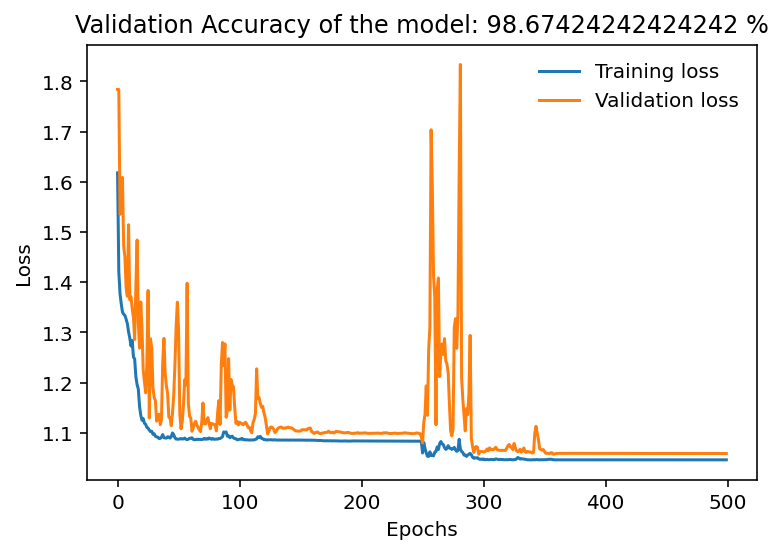

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Validation Accuracy of the model: {} %'.format(max_valid_accuracy))
plt.legend(frameon=False)

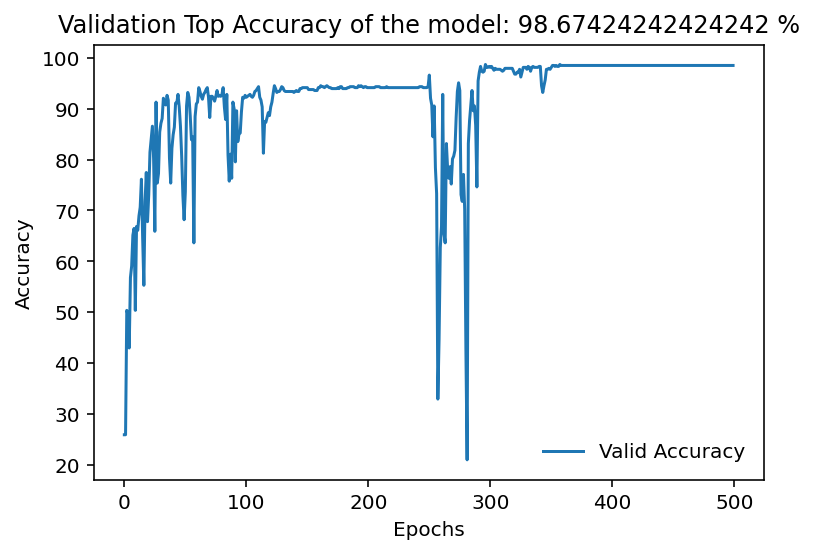

In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(valid_accuracy_list, label='Valid Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Validation Top Accuracy of the model: {} %'.format(max_valid_accuracy))
plt.legend(frameon=False)